<a href="https://colab.research.google.com/github/dsercam/TC033/blob/main/TC4033_Activity1b_ID44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='darkorange'><b> TC 5033 :: Advanced Machine Learning Methods </b> </font>
### <font color='darkgray'><b> Activity 1B :: Implementing a Fully Connected Network for *Kaggle ASL Dataset* </b></font></br></br>
###<font color='darkblue'><b>  Group 44 </b></font>
***Dante Rodrigo Serna Camarillo A01182676***

In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import string
import matplotlib.pyplot as plt
import cv2 as cv
import os
import math

### <font color="darkblue"> **1. Import data set** </font>
>>Data sets were loaded into Google drive and exposed to the public.
</br>
>>Then we use the *requests* method to retrieve the files using the downloads URLs.

In [2]:
url = 'https://drive.google.com/uc?export=download&id=1ttUEqCDuNFIenzrr4kMCHkbvBIy9fHmy'
ASLTrainSet = requests.get(url)

url = 'https://drive.google.com/uc?export=download&id=1mbEOJQKvhw41DpBzBB9PSfPr3IsngfA7'
ASLValidationSet = requests.get(url)

>> Get the streamed data into a String format, then read it as CSV format using *read_csv*, assign them to two data frames.
</Br>
>>> 1. <font color="darkorange"><b> *trainingDf* </b></font> contains the data of the training file
>>> 2. <font color="darkorange"><b> *validationDf* </b></font> contains the data of the validation file




In [3]:
trainingAsText = StringIO(ASLTrainSet.text)
validationAsText = StringIO(ASLValidationSet.text)

trainingDf = pd.read_csv(trainingAsText)
validationDf = pd.read_csv(validationAsText)

>> We can see the size of both sets.

In [4]:
print('Training set shape :: ',trainingDf.shape)
print('Validation set shape :: ',validationDf.shape)


Training set shape ::  (27455, 785)
Validation set shape ::  (7172, 785)


### <font color="darkblue"> **2. Clean Up data frames.** </font>
>>> Extract classification (*labels* column in both dataframes)
>>> After getting the classification, remove the link *label* column on both dataframes. This will only leave pixels information
</br>
>>> **y_train** :: (y) traning vector
</br>
>>> **y_validation** :: (y) validation vector

In [7]:
#Obtain classification for (y) for both sets on separate arrays
y_train = np.array(trainingDf['label'])
y_validation = np.array(validationDf['label'])

# Remove [label] column in both data frames
del trainingDf['label']
del validationDf['label']

#set data type as float in order to process it
x_train = trainingDf.values.astype(np.float32)
x_validation = validationDf.values.astype(np.float32)

### <font color="darkblue"> **3. Prepare plotting function.** </font>
>> Plot will help us graph an entry to see the ASL symbol.

In [8]:
def plot_ASL(image):
    #pixels = trainingDf.iloc[n,].to_numpy().astype('uint8') #this could have been used to parametrize the method in a different way.
    pixels = image.astype('uint8') # set type to uint8 for it to be graphed properly
    pixels = pixels.reshape(28,28) # reshape the row to (28x28)
    plt.figure(figsize=(5,5))
    plt.imshow(pixels.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()


>> Testing our plotting function using a random index.

ASL Symbol: 8


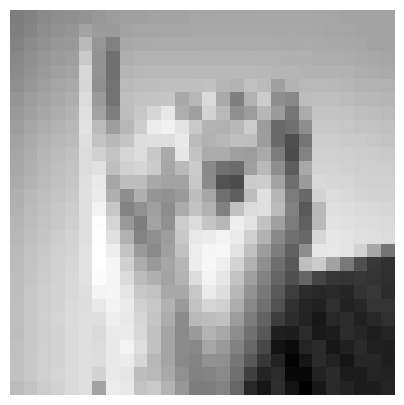

In [9]:
rnd_idx = np.random.randint(len(y_validation))
print(f'ASL Symbol: {y_validation[rnd_idx, ]}')
plot_ASL(x_validation[rnd_idx,])

### <font color="darkblue"> **4. About the datasets.** </font>
>> Some information about our datasets:
>>> **Current distribution:**


In [14]:
totalSamples = trainingDf.shape[0] + validationDf.shape[0] # total samples, including both sets
print('Current distirbution of our datasets:')
print(' Size of the training set: ',round((trainingDf.shape[0] *100)/totalSamples,2),'%')
print(' Size of the validation set: ',round((validationDf.shape[0]*100)/totalSamples,2),'%')

Current distirbution of our datasets:
 Size of the training set:  79.29 %
 Size of the validation set:  20.71 %


### <font color="darkblue"> **4.1 Create function to split a dataset given a percentage** </font>
> We will use this function to split our order *validation* set into two new sets, a new *test* set and a *validation* set.
>> - Method splits dataset in half (50%) by default. Parameter is defined as *pct* at method signature.
</br>
>> - Method shuffles given data set by default. Parameter is defined as *shuffle* at method signature.

In [15]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    #Validate the size of provided arguments, stop processing if number of records does not match.
    #Throws error if samples and y vector does not match.
    assert x.shape[0] == y.shape[0], 'Dataframe does not contain the same numer of records as Y (validation array)'

    # Number of samples, log to output
    dataCount = x.shape[0]
    print('Samples size as ', dataCount)

    #shuffle depending on shuffle parameter, shuffle True by default on method signature
    if shuffle:
        #generate a ndarray that conatins an entry/index for each row of the data
        idxs = np.arange(dataCount)
        #Shuffle the indexes
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    #Describe how are going to split the given data set, based on the provided pct parameter.
    #If the PCT does not result in a intger count, we round up to the next integer.
    print('Will split data set at ', pct ,'%.')
    if((dataCount*pct).is_integer()) : print(pct, '% of the total records = ',dataCount*pct)
    else: print(pct, '% of the total records = ',dataCount*pct, ' will round up to next integer (',math.ceil(dataCount*pct),').')

    #creat a copy of the data set (both the samples and y vector), these structures will be used as the 'test' sets.
    x_test = x.copy()
    y_test = y.copy()

    x_val = x[:math.ceil(dataCount*pct)-1].reshape(math.ceil(dataCount*pct)-1, -1).astype(float)
    y_val = y[:math.ceil(dataCount*pct)-1].reshape(math.ceil(dataCount*pct)-1, 1)

    x_test = x_test[math.trunc(dataCount*pct):].reshape(math.ceil(dataCount*pct), -1).astype(float)
    y_test = y_test[math.trunc(dataCount*pct):].reshape(math.ceil(dataCount*pct), 1)
    pass
    #return validation sets, followed by test sets
    return x_val, y_val, x_test, y_test


### <font color="darkblue"> **4.2 Use the _split_val_test()_ function to split our validation set into a validation and testing data sets** </font>


In [16]:
x_val, y_val, x_test, y_test = split_val_test(x_validation, y_validation)

Samples size as  7172
Will split data set at  0.5 %.
0.5 % of the total records =  3586.0


>> - Our final distibution of data sets as:

In [17]:
print('[Y] Training set shape: ',y_train.shape)
print('[x] Training set shape: ',x_train.shape)
print('[Y] Validation set shape: ',y_val.shape)
print('[x] validation set shape: ',x_val.shape)
print('[Y] Test set shape: ',y_test.shape)
print('[x] Test set shape: ',x_test.shape)

[Y] Training set shape:  (27455,)
[x] Training set shape:  (27455, 784)
[Y] Validation set shape:  (3585, 1)
[x] validation set shape:  (3585, 784)
[Y] Test set shape:  (3586, 1)
[x] Test set shape:  (3586, 784)


>> Execute this as per the provided instructions, will remove 'j' and 'z' symbols
</br>
>> This results in having a total of 24 classes.

In [19]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print('Number of classes: ',len(alphabet))

Number of classes:  24


### <font color="darkblue"> **5. Normalize data** </font>
>> Normalization will be applied using mean and std of the training data set.

In [20]:
print('Current mean (training data set):', x_train.mean())
print('Current standard deviation (training data set):', x_train.std())

Current mean (training data set): 159.29083
Current standard deviation (training data set): 48.76953


>> Create function to normalize data sets.
</br>

In [21]:
#parameters include the mean, standard deviation and the data structure to normalize.
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [23]:
#save mean and standard deviation our our training data set.
x_mean = x_train.mean()
x_std = x_train.std()

>> We will create a copy of each our samples data frames, that wat we can use such structures to plot our original images. These _raw_ dataframes are:
>>> *x_train_raw* </br>
>>> *x_val_raw*  </br>
>>> *x_test_raw*  </br>

>> We will normalize our three samples dataframe and assign the normalize data to them. Dataframes are kept as:
>>> *x_train* </br>
>>> *x_val*  </br>
>>> *x_test* </br>

In [24]:
x_train_raw = x_train.copy()
x_val_raw = x_val.copy()
x_test_raw = x_test.copy()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [26]:
print('[x_train] mean after normalization:',x_train.mean())
print('[x_train] std deviation after normalization:',x_train.std())
print('[x_val] mean after normalization:',x_val.mean())
print('[x_val] std deviation after normalization:',x_val.std())
print('[x_test] mean after normalization:',x_test.mean())
print('[x_test] std deviation after normalization:',x_test.std())

[x_train] mean after normalization: -2.4830147e-08
[x_train] std deviation after normalization: 1.0
[x_val] mean after normalization: 0.023387816274673907
[x_val] std deviation after normalization: 1.0112808714397006
[x_test] mean after normalization: 0.02937074309409674
[x_test] std deviation after normalization: 0.9997438574068822


### <font color="darkblue"> **6. Create mini batches function** </font>
>>

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [ ]:
class np_tensor(np.ndarray): pass

In [ ]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)

In [ ]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

In [ ]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

In [ ]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

In [ ]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [ ]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [ ]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 24)])
mb_size = 512
learning_rate = 1e-4
epochs = 20


In [ ]:
train(model, epochs, mb_size, learning_rate)

costo: 1.1322793032140241, accuracy: 0.5525801952580195
costo: 0.5583629652543898, accuracy: 0.6635983263598326
costo: 0.325101989819826, accuracy: 0.697907949790795
costo: 0.20883056538983324, accuracy: 0.7227336122733612
costo: 0.17182959254366603, accuracy: 0.7408647140864714
costo: 0.13083439295257832, accuracy: 0.7405857740585774
costo: 0.09141680670987015, accuracy: 0.7520223152022315
costo: 0.07127213078913265, accuracy: 0.7520223152022315
costo: 0.057310307840020676, accuracy: 0.7609483960948397
costo: 0.042106683728079526, accuracy: 0.7615062761506276
costo: 0.03806048421157878, accuracy: 0.7665271966527196
costo: 0.030049003093580474, accuracy: 0.7637377963737796
costo: 0.02301456899564194, accuracy: 0.7595536959553696
costo: 0.023633530553152583, accuracy: 0.7684797768479776
costo: 0.02331591828274149, accuracy: 0.7673640167364016
costo: 0.018209521354174408, accuracy: 0.7629009762900977
costo: 0.022905111096923794, accuracy: 0.7707112970711297
costo: 0.018777464307707176, a

In [ ]:
print(accuracy(x_test, y_test, mb_size))

0.7707752370329057


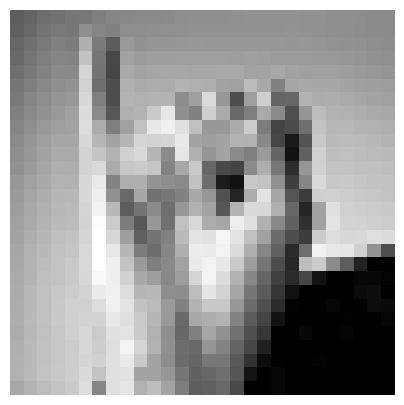

el valor predicho es: 8, el valor real es:8


In [ ]:
idx = np.random.randint(len(y_test))
plot_ASL(x_test_raw[idx,])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')